In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv, calculate_season_average_until_gw
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "ga_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

Sample of X_train (features):
       value  opponent_defense  own_attack  rolling_expected_goals_5  \
8244      54              1090        1140                  0.036039   
55820     45              1050        1020                  0.014726   
11204     50              1145        1150                  0.000000   
2671      46              1100        1120                  0.002650   
20739     50              1120        1340                  0.003153   

       average_expected_goals_season  rolling_shots_5  \
8244                        0.129049              0.6   
55820                       0.014726              0.2   
11204                       0.000000              0.0   
2671                        0.000000              0.2   
20739                       0.038316              0.2   

       rolling_expected_goals_10  
8244                    0.073089  
55820                   0.024866  
11204                   0.007595  
2671                    0.028093  
20739              

<Figure size 1000x800 with 0 Axes>

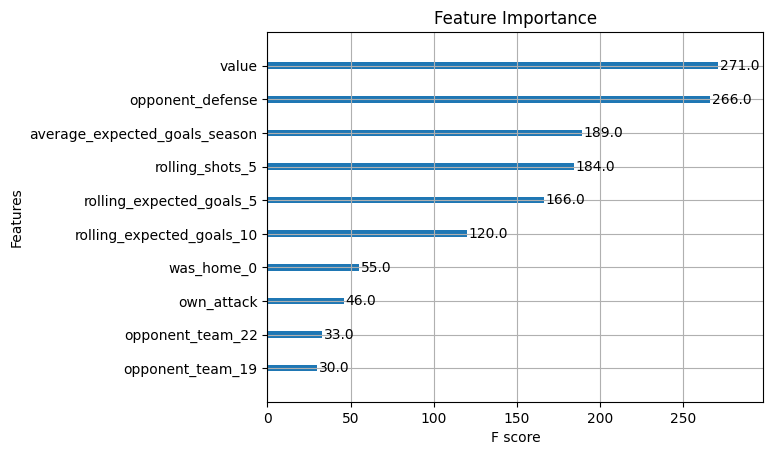

In [24]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data = data.sort_values(by=["unique_id", "season", "gameweek"])
data['expected_goals'] = data['expected_goals'].fillna(0)
data['shots'] = data['shots'].fillna(0)

data['rolling_expected_goals_5'] = data.groupby('unique_id')['expected_goals'].shift(1).rolling(window=5, min_periods=1).mean()
data['rolling_expected_goals_10'] = data.groupby('unique_id')['expected_goals'].shift(1).rolling(window=10, min_periods=1).mean()
data['rolling_shots_5'] = data.groupby('unique_id')['shots'].shift(1).rolling(window=5, min_periods=1).mean()

data['average_expected_goals_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='expected_goals',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

data['average_shots_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='shots',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "was_home", "unique_id", "own_team", "opponent_team", "penalties_order"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_expected_goals_5", "average_expected_goals_season", "rolling_shots_5", "rolling_expected_goals_10"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "expected_goals"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())


# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="ERROR")
        log(f"R-squared: {r2}", level="ERROR")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_expected_goals_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)

In [22]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
data = load_csv(training_file)
if data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
log("Applying feature engineering...", level="INFO")
MIN_MINUTES = 60

data = data[data['minutes'] >= MIN_MINUTES]

# Remove gameweek 1 from data
data = data[data['gameweek'] > 1]

data['was_home'] = data['was_home'].astype(int)
data['key_passes'] = data['key_passes'].fillna(0)
data['shots'] = data['shots'].fillna(0)
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xa_5'] = data.groupby('unique_id')['expected_assists'].shift(1).rolling(window=5, min_periods=1).mean()
data['rolling_key_passes_5'] = data.groupby('unique_id')['key_passes'].shift(1).rolling(window=5, min_periods=1).mean()
data['rolling_shots_5'] = data.groupby('unique_id')['shots'].rolling(window=5, min_periods=1).mean()

data['average_xa_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='expected_assists',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)
data['average_key_passes_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='key_passes',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)
data['average_shots_season'] = calculate_season_average_until_gw(
    data=data,
    value_column='shots',
    group_columns=['unique_id', 'season'],
    current_column='gameweek'
)

# One-hot encoding for categorical features
dummy_columns = ["POS", "was_home", "unique_id", "own_team", "opponent_team"]
data = pd.get_dummies(data, columns=dummy_columns)

# Define features
numerical_features = [
    "value", "opponent_defense", "own_attack",
    "rolling_xa_5", "average_xa_season", "rolling_key_passes_5", "average_key_passes_season",
    "rolling_shots_5", "average_shots_season"
]
categorical_features = [
    col for col in data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features

TARGET_COLUMN = "expected_assists"
X = data[features]
y = data[TARGET_COLUMN]

# ========================
# Train-Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Sample of X_train (features):")
print(X_train[numerical_features].head())

# ========================
# Model Training
# ========================
def train_model(X_train, y_train, X_test, y_test):
    log("Training model...", level="INFO")
    try:
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        log(f"RMSE: {rmse}", level="ERROR")
        log(f"R-squared: {r2}", level="ERROR")
        return model
    except Exception as e:
        log(f"Error during model training: {e}", level="ERROR")
        raise

model = train_model(X_train, y_train, X_test, y_test)

# ========================
# Feature Importance
# ========================
log("Plotting feature importance...", level="INFO")
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()

# ========================
# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xa_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)

TypeError: incompatible index of inserted column with frame index